In [1]:
from src.models.vae import VAE
from src.trainer import HierachicalVAETrainer
from src.utils.display_utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from tqdm import tqdm
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
from src.utils import StyledMNISTGenerator, StyledMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
np.random.seed(101)
torch.manual_seed(101)

generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.15,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.1,
        lambda x: corruptions.scale(x, 5): 0.1,
        corruptions.brightness: 0.2
    },
)


In [8]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3945.97item/s]


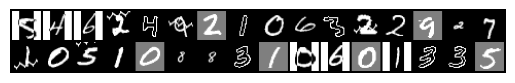

In [9]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [10]:
Z_DIM = 16

vae = VAE(total_z_dim=Z_DIM, group_mode="GVAE").to(device)
train_loader = DataLoader(train, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = HierachicalVAETrainer(
    vae,
    optimizer,
    hyperparameter={"beta": 1 / 8, "loc": 0, "scale": 1},
    verbose_period=5,
    device=device,
)

In [11]:
trainer.fit(51, train_loader, valid_loader, with_evidence_acc=True)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 111.16it/s]


val_recontr_loss=56.456, val_kl_c=23.241, val_kl_s=16.585
gMIG: 0.397; elbo: -96.283


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 115.61it/s]


val_recontr_loss=29.130, val_kl_c=25.011, val_kl_s=17.756
gMIG: 0.508; elbo: -71.897


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 120.25it/s]


val_recontr_loss=23.952, val_kl_c=22.828, val_kl_s=18.750
gMIG: 0.531; elbo: -65.53


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 123.61it/s]


val_recontr_loss=21.759, val_kl_c=25.051, val_kl_s=18.657
gMIG: 0.553; elbo: -65.468


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 118.66it/s]


val_recontr_loss=20.529, val_kl_c=25.081, val_kl_s=19.059
gMIG: 0.568; elbo: -64.669


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 116.36it/s]


val_recontr_loss=19.710, val_kl_c=24.252, val_kl_s=19.772
gMIG: 0.568; elbo: -63.734


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 120.12it/s]


val_recontr_loss=18.979, val_kl_c=24.365, val_kl_s=20.053
gMIG: 0.57; elbo: -63.396


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 119.21it/s]


val_recontr_loss=18.590, val_kl_c=25.800, val_kl_s=20.217
gMIG: 0.588; elbo: -64.607


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 120.94it/s]


val_recontr_loss=18.220, val_kl_c=25.565, val_kl_s=20.823
gMIG: 0.584; elbo: -64.608


val-epoch 45: 100%|██████████| 79/79 [00:00<00:00, 118.28it/s]


val_recontr_loss=18.250, val_kl_c=25.728, val_kl_s=20.421
gMIG: 0.58; elbo: -64.399


val-epoch 50: 100%|██████████| 79/79 [00:00<00:00, 106.49it/s]


val_recontr_loss=18.110, val_kl_c=25.248, val_kl_s=20.368
gMIG: 0.579; elbo: -63.726


In [12]:
trainer.evaluate(test_loader, False, 0, with_evidence_acc=False)

(0.2352872064780374, -63.66368185902556)

In [13]:
def _helper(group_mu, label):
    c_idx_dict = {}
    for _c in label.unique():
        c_idx_dict[_c.item()] = torch.where(label == _c)[0]
    device = group_mu.device
    indices = torch.cat(list(c_idx_dict.values())).to(device)
    inverse_indices = torch.zeros_like(indices)
    inverse_indices[indices] = torch.arange(len(indices)).to(device)
    select = torch.cat(
        [torch.tensor([i] * len(idx)) for i, idx in enumerate(c_idx_dict.values())]
    ).to(device)
    return torch.index_select(group_mu, 0, select)[inverse_indices]

In [14]:
with_evidence_acc = False
mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(valid_loader):
        X = X.to(device)
        label = label.to(device)

        
        if with_evidence_acc:
            _, latent_params = vae(X, label)
            mu_cs.append(_helper(latent_params['mu_c'], label))
        else:
            _, latent_params = vae(X)
            mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 351.59it/s]


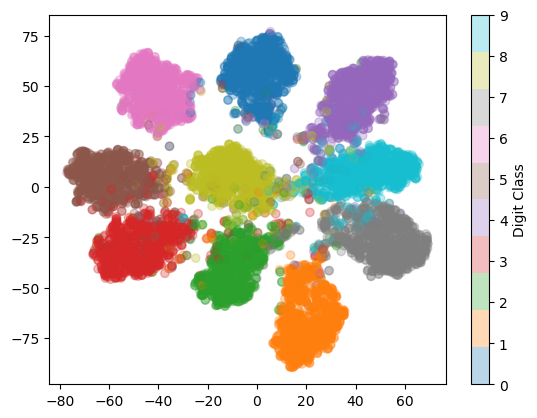

In [15]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
mu_cs_tsne = tsne.fit_transform(mu_cs.detach().cpu().numpy())

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

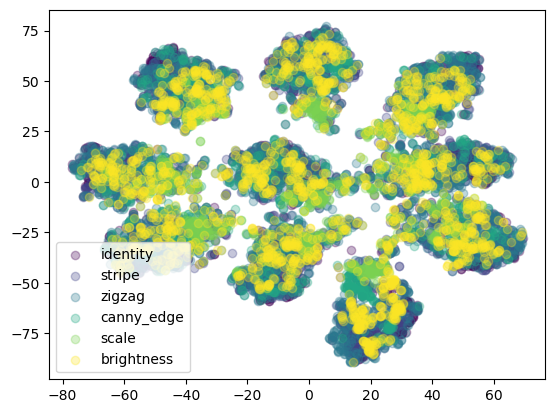

In [16]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [17]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

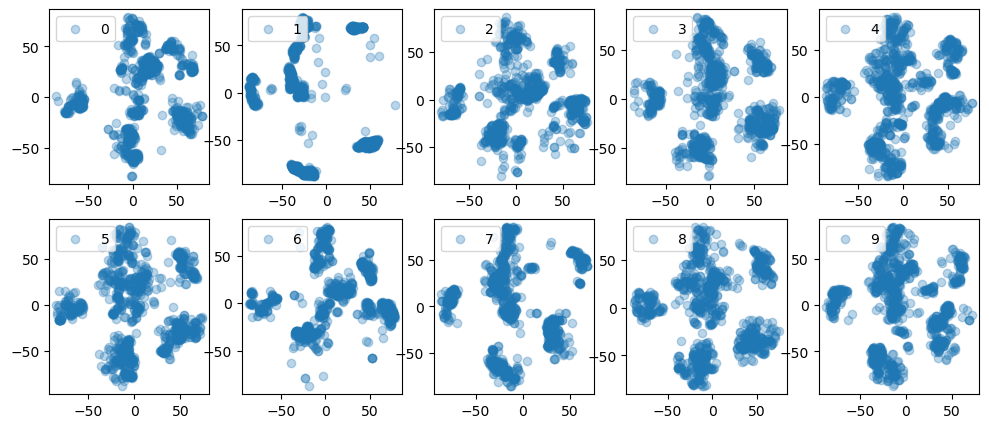

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

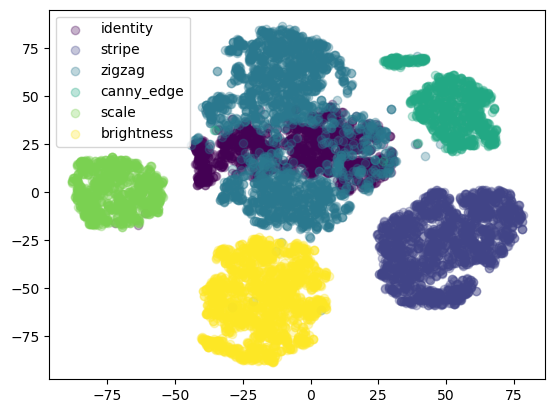

In [19]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [20]:
torch.manual_seed(101)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), c, explicit=True) # here inputing c labels => evidence acc


In [21]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]

In [22]:
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

In [23]:
# illustration using all s
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())


In [24]:
with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    x_inter = vae.decode(paired_z)
    maingrid = make_grid(x_inter, nrow=12)

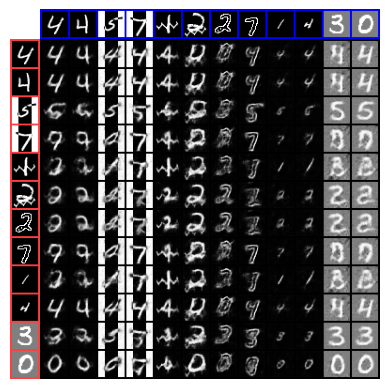

In [25]:
from expr.visual_utils import feature_swapping_plot

feature_swapping_plot(z_c, z_s, X[img_idx], vae)

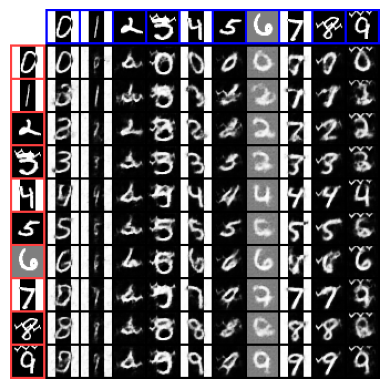

In [26]:
# illustration using all c
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape

feature_swapping_plot(z_c, z_s, X[img_idx], vae)


In [27]:
from expr.visual_utils import interpolation_plot

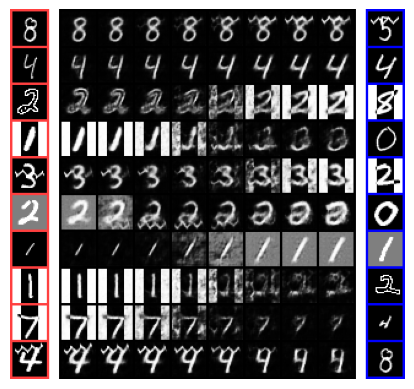

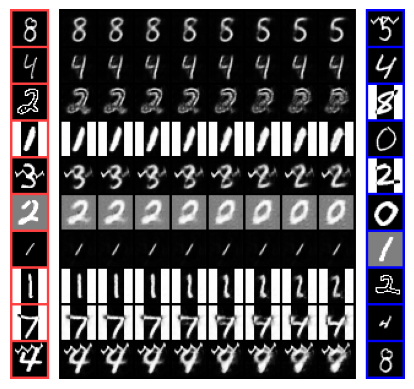

In [28]:
interpolation_plot(X, z, vae, int(Z_DIM / 2), inter_steps=8)